# WrexGPT - example of usage
- it was trained on google colab

# Imports

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataclasses import dataclass
from typing import Literal

import math

from tqdm.auto import tqdm

import numpy as np

import tiktoken

import ftfy

from matplotlib import pyplot as plt

import gc
gc.collect()
torch.cuda.empty_cache()

# ------ DEFINITIONS -------

# Layers

## Attention

In [2]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, dim_in, dim_out, context_length, num_heads=12, dropout=0.1, bias=False):
        super().__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out

        if (dim_out % num_heads) != 0:
            raise ValueError("dim_out must be divisible by num_heads")

        self.num_heads = num_heads
        self.context_length = context_length
        self.dropout = nn.Dropout(dropout)
        self.head_dim = dim_out // num_heads

        self.w_query = nn.Linear(dim_in, dim_out, bias=bias)
        self.w_key = nn.Linear(dim_in, dim_out, bias=bias)
        self.w_value = nn.Linear(dim_in, dim_out, bias=bias)

        self.softmax = nn.Softmax(dim=-1)

        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

        self.out_projection = nn.Linear(dim_out, dim_out)
        self.out_projection.RESIDUAL_INIT = 1

    # INPUT x = (batch_size = 2, context_len = 3, dim_in = 968)
    def forward(self, x, padding_mask=None):
        batch_size, context_length, dim_in = x.shape

        # x = (batch_size = 2, context_len = 3, dim_out = 968)
        q = self.w_query(x)
        k = self.w_key(x)
        v = self.w_value(x)

        # we have to split each encoded sentence for head
        # x = (batch_size = 2, context_len = 3, num_heads = 8, head_dim = 121)
        q = q.view(batch_size,context_length, self.num_heads, self.head_dim)
        k = k.view(batch_size,context_length, self.num_heads, self.head_dim)
        v = v.view(batch_size,context_length, self.num_heads, self.head_dim)

        # now we have per batch-head sample, each batch, have heads wich have specific subspace of mapping
        # x = (batch_size = 2, num_heads = 8,context_len = 3, head_dim = 121)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # now we want to have (batch_size, num_heads, context_len, context_len)
        # x = (batch_size = 2, num_heads = 8, context_len = 3, context_len = 3)
        att_score = q @ k.transpose(2, 3)
        att_score = att_score / math.sqrt(self.head_dim)

        # now masking
        # but if sentences are not == context_len then mask is truncated
        mask = self.mask.bool()[0:context_length, 0:context_length]
        # trio mask
        att_score = att_score.masked_fill_(mask, torch.finfo(att_score.dtype).min)
        # padding mask
        if padding_mask is not None:
            att_score = att_score.masked_fill_(padding_mask, torch.finfo(att_score.dtype).min)



        # softmax + dropout
        att_score = self.softmax(att_score)
        att_score = self.dropout(att_score)

        # (batch_size, num_heads, context_len, context_len) * (batch_size, num_heads,context_len, head_dim)
        # we want to have once again
        # (batch_size = 2, num_heads = 8,context_len = 3, head_dim = 121) not attention scores
        context_vec = att_score @ v

        # now lets revert to
        # (batch_size = 2,context_len = 3, num_heads = 8, head_dim = 121)
        context_vec = context_vec.transpose(1, 2)

        # now lets concatenate all the head so we have like at the beggining
        # (batch_size = 2, context_len = 3, dim_out = 968)
        context_vec = context_vec.contiguous().view(batch_size, context_length, self.dim_out)
        context_vec = self.out_projection(context_vec)
        return context_vec




## MLP

In [3]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, dim_in, dim_hidden):
        super().__init__()

        self.l1 = nn.Linear(dim_in, dim_hidden)

        self.gelu = nn.GELU()

        self.l2 = nn.Linear(dim_hidden, dim_in)
        self.l2.RESIDUAL_INIT = 1

    def forward(self, x):
        x = self.l1(x)
        x = self.gelu(x)
        x = self.l2(x)
        return x

## Positional Encoding

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, context_length, dim_embedded):
        super().__init__()
        self.position_embedding = nn.Embedding(context_length, dim_embedded)

    def forward(self, sentence_length, device):
        # pos = (, context_len)
        pos = torch.arange(sentence_length, device=device, dtype=torch.long)
        # pos_emb = (, context_len, embedded_dim)
        pos_emb = self.position_embedding(pos)
        return pos_emb


## Transformer

In [5]:
# Decoder only, transormer like block
class TransformerDecoder(nn.Module):
    def __init__(self, dim_embedded, context_length, num_heads, dropout=0.1, qkv_bias=False):
        super().__init__()
        self.dim_embedded = dim_embedded
        self.context_length = context_length

        self.attention = MaskedMultiHeadAttention(dim_in=self.dim_embedded, dim_out=self.dim_embedded, context_length=context_length, num_heads=num_heads, dropout=dropout, bias=qkv_bias)

        self.mlp = MultiLayerPerceptron(dim_in=self.dim_embedded, dim_hidden=self.dim_embedded*4)

        self.ln1 = nn.LayerNorm(self.dim_embedded)
        self.ln2 = nn.LayerNorm(self.dim_embedded)

        self.dropout_attn = nn.Dropout(dropout)
        self.dropout_mlp = nn.Dropout(dropout)

    # x = (batch_size, context_len, embedded_dim)
    def forward(self, x, mask=None):

        # x = (batch_size, context_len, embedded_dim)
        # throguh out all transformer it is the same size
        identity = x
        x = self.ln1(x)
        x = self.attention(x, mask)
        x = self.dropout_attn(x)
        x = x + identity

        identity = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = self.dropout_mlp(x)
        x = x + identity

        # x = x + self.dropout_attn(self.attention(self.ln1(x)))
        # x = x + self.dropout_mlp(self.mlp(self.ln2(x)))

        # x = (batch_size, context_len, embedded_dim)
        return x


# Hyperparameters

## Model hypers

In [6]:
@dataclass
class ModelConfig:
    """Base model configuration that can be initialized for different GPT-2 variants."""
    dim_embedded: int
    context_length: int
    num_heads: int
    layers: int
    dropout: float
    gradient_checkpointing: bool = True
    vocab_size: int = 50258
    padding_token: int = 50257

    @classmethod
    def from_preset(cls, preset: Literal["gpt2", "gpt2-mini"] = "gpt2"):
        """Create a model configuration from a preset.

        Args:
            preset: Either "gpt2" or "gpt2-mini"
        """
        configs = {
            "gpt2-test": {
                "dim_embedded": 2,
                "context_length": 2,
                "num_heads": 1,
                "layers": 1,
                "dropout": 0.2,
            },
            "gpt2-mini": {
                "dim_embedded": 384,
                "context_length": 256,
                "num_heads": 6,
                "layers": 6,
                "dropout": 0.2,
            },
            "gpt2": {
                "dim_embedded": 768,
                "context_length": 1024,
                "num_heads": 12,
                "layers": 12,
                "dropout": 0.1,
            }
        }

        if preset not in configs:
            raise ValueError(f"Unknown preset: {preset}. Choose from {list(configs.keys())}")

        return cls(**configs[preset])


    def __repr__(self) -> str:
        """Pretty print configuration."""
        class_name = self.__class__.__name__
        fields = []
        max_key_length = max(len(key) for key in self.__dataclass_fields__.keys())

        for key, value in self.__dict__.items():
            padding = " " * (max_key_length - len(key))
            fields.append(f"  {key}{padding} = {value}")

        fields_str = "\n".join(fields)
        return f"{class_name}(\n{fields_str}\n)"

## Training hypers

In [7]:
@dataclass
class TrainConfig:
    """Base training configuration that can be initialized for different GPT-2 variants."""
    total_steps: int
    max_lr: float
    batch_size: int
    accumulation_batch_size: int
    weight_decay: float
    grad_clip: float
    device: str
    scale_factor: float
    info_decay: int
    checkpoint_decay: int
    warmup_steps: int
    early_stopper_patience: int
    epochs: int = -1
    padding_token: int = 50257
    use_amp: bool = None

    def __post_init__(self):
        """Set use_amp based on CUDA availability if not explicitly set."""
        if self.use_amp is None:
            self.use_amp = torch.cuda.is_available()

    @classmethod
    def from_preset(cls, preset: Literal["gpt2", "gpt2-mini"] = "gpt2"):
        """Create a training configuration from a preset.

        Args:
            preset: Either "gpt2" or "gpt2-mini"
        """
        configs = {
            "gpt2-test": {
                "total_steps": 100,
                "max_lr": 5e-4,
                "batch_size": 256,
                "accumulation_batch_size": 1024,
                "weight_decay": 0.1,
                "grad_clip": 1.0,
                "scale_factor": 2.0,
                "warmup_steps": 10,
                "early_stopper_patience": 10,
                "info_decay": 10,
                "checkpoint_decay": 10
            },
            "gpt2-mini": {
                "total_steps": 100000,
                "max_lr": 2.5e-4,
                "batch_size": 16,
                "accumulation_batch_size": 64,
                "weight_decay": 0.2,
                "grad_clip": 1.0,
                "scale_factor": 2.0,
                "warmup_steps": 4000,
                "early_stopper_patience": 18,
                "info_decay": 500,
                "checkpoint_decay": 500

            },
            "gpt2": {
                "total_steps": 2000,
                "max_lr": 6e-4,
                "batch_size": 8,
                "accumulation_batch_size": 64,
                "weight_decay": 0.1,
                "grad_clip": 1.0,
                "scale_factor": 2.0,
                "warmup_steps": 200,
                "early_stopper_patience": 10,
                "info_decay": 50,
                "checkpoint_decay": 25
            }
        }

        if preset not in configs:
            raise ValueError(f"Unknown preset: {preset}. Choose from {list(configs.keys())}")

        device = "cuda" if torch.cuda.is_available() else "cpu"

        return cls(
            **configs[preset],
            device=device,
        )

    def __repr__(self) -> str:
        """Pretty print configuration."""
        class_name = self.__class__.__name__
        fields = []
        max_key_length = max(len(key) for key in self.__dataclass_fields__.keys())

        for key, value in self.__dict__.items():
            padding = " " * (max_key_length - len(key))
            fields.append(f"  {key}{padding} = {value}")

        fields_str = "\n".join(fields)
        return f"{class_name}(\n{fields_str}\n)"

# Model definition

In [8]:
class WrexGPT(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.gradient_checkpointing = config.gradient_checkpointing

        self.embedding = nn.Embedding(config.vocab_size, config.dim_embedded)
        self.positional_encoding = PositionalEncoding(config.context_length, config.dim_embedded)

        self.transformers = nn.ModuleList()
        for _ in range(config.layers):
            self.transformers.append(
                TransformerDecoder(
                    dim_embedded=config.dim_embedded,
                    context_length=config.context_length,
                    num_heads=config.num_heads,
                    dropout=config.dropout,
                    qkv_bias=False
                )
            )

        self.out_ln = nn.LayerNorm(config.dim_embedded)
        self.out_projection = nn.Linear(config.dim_embedded, config.vocab_size)

        self.apply(self.__init_weights)

    def __init_weights(self, module: nn.Module):
        if isinstance(module, nn.Linear):
            std = 0.02

            if hasattr(module, 'RESIDUAL_INIT'):
                std /= (2*self.config.layers)**0.5

            nn.init.normal_(module.weight, mean=0,std=std)

            if module.bias is not None:
                nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)

    # x = (batch_size, >= context_len)
    def forward(self, x):
        batch_size, sentence_length = x.shape
        assert sentence_length <= self.config.context_length

        # before all compute we have to calculate padding mask
        padding_token = self.config.padding_token

        # keep = (batch_size, context_len)
        keep = (x != padding_token)  # (B, C) bool, True = token
        # keep2d = (batch_size, context_len, context_en)
        keep2d = keep.unsqueeze(2) & keep.unsqueeze(1)
        mask_pad = ~keep2d
        # mask_pad = (batch_size, 1, context_len, context_len)
        mask_pad = mask_pad.unsqueeze(1)

        # first we embed
        # x = (batch_size, context_len, embedded_dim)
        emb_x = self.embedding(x)

        # then add postional learned encodding
        # x = (batch_size, context_len, embedded_dim)
        pos_x = self.positional_encoding(sentence_length, x.device)

        # summing up
        x = emb_x + pos_x

        # now grind through transformers
        for transformer in self.transformers:
            if self.gradient_checkpointing and self.training:
                x = torch.utils.checkpoint.checkpoint(transformer, x, mask_pad, use_reentrant=False)
            else:
                x = transformer(x, mask_pad)
        # finally normalization and linear layer
        # x = (batch_size, context_len, vocab_size)
        x = self.out_ln(x)
        x = self.out_projection(x)

        # logits out
        return x

# Trainer

## Trainer

In [9]:
class GPT2Trainer:
    def __init__(self, model: nn.Module, config: TrainConfig, train_loader, val_loader=None, earlystopper=None, checkpoint_path="./checkpoint.pt"):
        self.model = model
        self.model.to(config.device)

        self.config = config

        self.train_loader = train_loader
        self.val_loader = val_loader

        self.earlystopper = earlystopper
        self.is_earlystopped = False

        self.loss_fn = nn.CrossEntropyLoss(ignore_index=self.config.padding_token)

        if self.config.device == "cuda":
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.max_lr, fused=True)
        else:
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.max_lr, fused=False)

        self.scaler = torch.cuda.amp.GradScaler(enabled=(config.use_amp and "cuda" in config.device))

        self.current_step = 0
        self.current_epoch = 0

        self.path = checkpoint_path

        self.history = {
            "test_loss": [],
            "test_acc": [],
            "test_ppl": [],
            "val_loss": [],
            "val_acc": [],
            "val_ppl": [],
            "lr": []
        }


        if (self.config.accumulation_batch_size % self.config.batch_size != 0) or (self.config.accumulation_batch_size < self.config.batch_size):
            raise ValueError("Accumulated batch size has to be divisible by batch size and accumulated batch size cannot be less than batch size.")
        self.accumulation_step = self.config.accumulation_batch_size // self.config.batch_size

        if (self.config.epochs == -1 and self.config.total_steps == -1):
            raise ValueError("Bruh give number of epochs or total steps")
        elif (self.config.epochs != -1 and self.config.total_steps != -1):
            raise ValueError("Please specify only one epoch or total steps")

        warmup_steps = 0
        cosine_steps = 0

        if self.config.epochs != -1:
            self.epochs = self.config.epochs

            # calculating all steps based on dataloader len and accumulation step size
            self.total_steps = math.ceil((len(self.train_loader)/self.accumulation_step)*self.epochs)
            warmup_steps = self.config.warmup_steps
            cosine_steps = self.total_steps - self.config.warmup_steps
        elif self.config.total_steps != -1:
            self.total_steps = self.config.total_steps
            self.epochs = self.config.epochs
            warmup_steps = self.config.warmup_steps
            cosine_steps = self.total_steps - self.config.warmup_steps



        warmup = LinearLR(self.optimizer,
                  start_factor=1e-8,
                  end_factor=1.0,
                  total_iters=max(0,warmup_steps))

        cosine = CosineAnnealingLR(self.optimizer,
                                   T_max= max(0,cosine_steps),
                                   eta_min=0)

        self.scheduler = SequentialLR(
            self.optimizer,
            schedulers=[warmup, cosine],
            milestones=[self.config.warmup_steps]
        )

    def __load_checkpoint(self):
        checkpoint = torch.load(self.path, map_location=self.config.device)

        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        self.config.__dict__.update(checkpoint["config"])

        if self.scheduler and checkpoint["scheduler_state_dict"] is not None:
            self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

        if self.config.use_amp and checkpoint["scaler_state_dict"] is not None:
            self.scaler.load_state_dict(checkpoint["scaler_state_dict"])

        if checkpoint["earlystopper_state_dict"] is not None and self.earlystopper is not None:
            self.earlystopper.load_state_dict(checkpoint["earlystopper_state_dict"])

        self.is_earlystopped = checkpoint["is_earlystopped"]

        self.history = checkpoint["history"]

        self.path = checkpoint["path"]
        self.accumulation_step = checkpoint["accumulation_step"]

        self.current_step = checkpoint["current_step"]
        self.current_epoch = checkpoint["current_epoch"]

        print(f"Checkpoint loaded from {self.path}")

    def __save_checkpoint(self):

        checkpoint = {
            "current_epoch": self.current_epoch,
            "current_step": self.current_step,
            "accumulation_step": self.accumulation_step,
            "path": self.path,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "scheduler_state_dict": self.scheduler.state_dict() if self.scheduler else None,
            "earlystopper_state_dict": self.earlystopper.state_dict() if self.earlystopper else None,
            "is_earlystopped": self.is_earlystopped,
            "scaler_state_dict": self.scaler.state_dict() if self.config.use_amp else None,
            "history": self.history,
            "config": self.config.__dict__
        }

        torch.save(checkpoint, self.path)

    def __calculate_loss(self, logits, y):
        # logits = (B, T, V)
        # y      = (B, T)
        B, T, V = logits.shape
        logits = logits.view(B * T, V)
        y = y.view(B * T)
        loss = self.loss_fn(logits, y)
        return loss

    @torch.no_grad()
    def __calculate_accuracy(self, logits, y):
        # logits = (B, T, V)
        # y      = (B, T)

        preds = logits.argmax(dim=-1)  # (B, T)
        mask = (y != self.config.padding_token)

        if mask.sum() == 0:
            return 0.0

        correct = ((preds == y) & mask).float().sum()
        total = mask.float().sum()
        return (correct / total).item()

    def __train_epoch(self):
        running_loss = 0.0
        running_acc = 0.0
        total_batches = 0

        self.model.train()
        self.optimizer.zero_grad(set_to_none=True)

        local_accumulation_step = min(self.accumulation_step, len(self.train_loader))

        for i,(X, y) in enumerate(tqdm(self.train_loader, desc=f"Training {self.current_epoch+1}", leave=False)):
            X,y = X.to(self.config.device, non_blocking=True), y.to(self.config.device, non_blocking=True)
            if self.config.use_amp:
                with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                    logits = self.model(X)
                    raw_loss = self.__calculate_loss(logits, y)
                    loss = raw_loss / local_accumulation_step

                self.scaler.scale(loss).backward()

                # doing gradient step only after "accumulation_step"
                if (i+1)%self.accumulation_step == 0 or (i+1) >= len(self.train_loader):
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.config.grad_clip)

                    self.scaler.step(self.optimizer)
                    if self.scheduler is not None:
                        self.scheduler.step()

                    self.scaler.update()

                    # gradient reset
                    self.optimizer.zero_grad(set_to_none=True)

                    self.current_step += 1
                    local_accumulation_step = min(self.accumulation_step, len(self.train_loader) - (i + 1))

            else:
                logits = self.model(X)
                raw_loss = self.__calculate_loss(logits, y)
                loss = raw_loss / local_accumulation_step

                loss.backward()

                # doing gradient step only after "accumulation_step"
                if (i+1)%self.accumulation_step == 0 or (i+1) >= len(self.train_loader):

                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.grad_clip)

                    self.optimizer.step()
                    if self.scheduler is not None:
                        self.scheduler.step()

                    # gradient reset
                    self.optimizer.zero_grad(set_to_none=True)

                    self.current_step += 1
                    local_accumulation_step = min(self.accumulation_step, len(self.train_loader) - (i + 1))

            # LOSS AND ACC CALCULATION
            running_loss += raw_loss.item()
            running_acc += self.__calculate_accuracy(logits.detach(), y)
            total_batches += 1



        # STATISTICS
        avg_loss = running_loss / max(1,total_batches)
        avg_acc = running_acc / max(1,total_batches)
        ppl = math.exp(min(avg_loss, 20))

        return avg_loss, avg_acc, ppl

    @torch.no_grad()
    def __validate_model(self):
        if self.val_loader is None:
            return 0.0, 0.0, 0.0

        self.model.eval()

        total_loss = 0.0
        total_acc = 0.0
        n_batches = 0

        for x, y in self.val_loader:
            x = x.to(self.config.device, non_blocking=True)
            y = y.to(self.config.device, non_blocking=True)

            logits = self.model(x)
            loss = self.__calculate_loss(logits, y)
            acc = self.__calculate_accuracy(logits, y)

            total_loss += loss.item()
            total_acc += acc
            n_batches += 1

        avg_loss = total_loss / max(1, n_batches)
        avg_acc = total_acc / max(1, n_batches)
        ppl = math.exp(min(avg_loss, 20))

        return avg_loss, avg_acc, ppl

    def train_epochs(self, revive_mode=False):
        if self.config.epochs == -1:
            raise ValueError("Number of epochs cannot be -1. Please speicfy nubmer of epochs.")

        if revive_mode:
            self.__load_checkpoint()

        # if we were early stopped we do not go with training
        if self.is_earlystopped:
            return self.history

        print("=" * 80)
        print("Starting training...")
        print(f"Total epochs: {self.epochs}")
        print(f"Current epoch: {self.current_epoch}")
        print("=" * 80)

        for epoch in tqdm(range(self.current_epoch, self.epochs), desc=f"Epoch {self.current_epoch+1}/{self.epochs}"):

            train_loss, train_acc, train_ppl = self.__train_epoch()
            print("\nValidating... ", end='')
            val_loss, val_acc, val_ppl = self.__validate_model()

            self.history["test_loss"].append(train_loss)
            self.history["test_acc"].append(train_acc)
            self.history["test_ppl"].append(train_ppl)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["val_ppl"].append(val_ppl)
            self.history["lr"].append(self.optimizer.param_groups[0]['lr'])

            # ======== PRINT RESULTS ========
            print(f"\nEpoch [{epoch + 1}/{self.epochs}]")
            print("-" * 60)
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train PPL: {train_ppl:.2f}")
            print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val   PPL: {val_ppl:.2f}")
            print(f"LR: {self.optimizer.param_groups[0]['lr']:.6e}")
            print("-" * 60)

            # ======== EARLY STOPPING ========
            if self.earlystopper is not None:
                should_stop = self.earlystopper.step(val_loss, self.model, epoch)

                if should_stop:
                    self.is_earlystopped = True
                    print("\nCheckpoint and early stopping... ")
                    break

            # ======== UPDATE EPOCHS ========
            self.current_epoch += 1

            # ======== SAVE CHECKPOINT ========
            self.__save_checkpoint()


        print("\nTraining finished.")
        return self.history

    def train_steps(self, revive_mode=False):
        if self.config.total_steps == -1:
            raise ValueError("total_steps cannot be -1. Specify the number of steps")

        if revive_mode:
            self.__load_checkpoint()

        # if we were early stopped we do not go with training
        if self.is_earlystopped:
            return self.history

        print("=" * 80)
        print("Starting training...")
        print(f"Total steps: {self.total_steps}")
        print(f"Current step: {self.current_step}")
        print("=" * 80)

        progress_bar = tqdm(total=self.total_steps)
        progress_bar.update(self.current_step)
        progress_bar.refresh()

        running_loss = 0.0
        running_acc = 0.0
        total_batches = 0

        self.model.train()
        self.optimizer.zero_grad(set_to_none=True)

        if self.current_step >= self.total_steps:
            working = False
        else:
            working = True

        while working:
            local_accumulation_step = min(self.accumulation_step, len(self.train_loader))
            for i, (X, y) in enumerate(self.train_loader):
                X, y = X.to(self.config.device, non_blocking=True), y.to(self.config.device, non_blocking=True)

                # COMPUTING AND STEPPING
                if self.config.use_amp:
                    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                        logits = self.model(X)
                        raw_loss = self.__calculate_loss(logits, y)
                        loss = raw_loss / local_accumulation_step

                    self.scaler.scale(loss).backward()

                    # doing gradient step only after "accumulation_step"
                    if (i + 1) % self.accumulation_step == 0 or (i + 1) >= len(self.train_loader):
                        self.scaler.unscale_(self.optimizer)
                        torch.nn.utils.clip_grad_norm_(parameters=self.model.parameters(),
                                                       max_norm=self.config.grad_clip)

                        self.scaler.step(self.optimizer)
                        if self.scheduler is not None:
                            self.scheduler.step()

                        self.scaler.update()

                        # gradient reset
                        self.optimizer.zero_grad(set_to_none=True)

                        self.current_step += 1
                        progress_bar.update(1)
                        local_accumulation_step = min(self.accumulation_step, len(self.train_loader) - (i+1))
                else:
                    logits = self.model(X)
                    raw_loss = self.__calculate_loss(logits, y)
                    loss = raw_loss / local_accumulation_step

                    loss.backward()

                    # doing gradient step only after "accumulation_step"
                    if (i + 1) % self.accumulation_step == 0 or (i + 1) >= len(self.train_loader):

                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.grad_clip)

                        self.optimizer.step()
                        if self.scheduler is not None:
                            self.scheduler.step()

                        # gradient reset
                        self.optimizer.zero_grad(set_to_none=True)

                        self.current_step += 1
                        progress_bar.update(1)
                        local_accumulation_step = min(self.accumulation_step, len(self.train_loader) - (i+1))



                # LOSS AND ACC CALCULATION
                running_loss += raw_loss.item()
                running_acc += self.__calculate_accuracy(logits.detach(), y)
                total_batches += 1

                # INFO CHECKPOINT
                if ((self.current_step % self.config.info_decay == 0) and ((i + 1) % self.accumulation_step == 0 or (i + 1) >= len(self.train_loader))) or (self.current_step == 0 and i == 0):
                    # STATISTICS
                    print("\nValidating... ", end='')

                    train_loss = running_loss / max(1, total_batches)
                    train_acc = running_acc / max(1, total_batches)
                    train_ppl = math.exp(min(train_loss, 20))

                    val_loss, val_acc, val_ppl = self.__validate_model()

                    # saving hisotry
                    self.history["test_loss"].append(train_loss)
                    self.history["test_acc"].append(train_acc)
                    self.history["test_ppl"].append(train_ppl)
                    self.history["val_loss"].append(val_loss)
                    self.history["val_acc"].append(val_acc)
                    self.history["val_ppl"].append(val_ppl)
                    self.history["lr"].append(self.optimizer.param_groups[0]['lr'])

                    # reset stats
                    running_loss = 0.0
                    running_acc = 0.0
                    total_batches = 0

                    # write down
                    print(
                        f"[Step {self.current_step}] "
                        f"Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
                        f"Val Loss: {val_loss:.4f} | Val acc: {val_acc:.4f}"
                    )

                    # early stopper step
                    if self.earlystopper is not None:
                        if self.earlystopper.step(val_loss, self.model, self.current_step):
                            self.is_earlystopped = True
                            print("\nCheckpoint and early stopping... ")
                            self.__save_checkpoint()
                            working = False
                            break

                    self.model.train()

                # SAVING CHECKPOINT
                if (self.current_step % self.config.checkpoint_decay == 0) and ((i + 1) % self.accumulation_step == 0 or (i + 1) >= len(self.train_loader)):
                    print("\nCheckpoint... ")
                    self.__save_checkpoint()

                # BREAKING OUT THE LOOP
                if  self.current_step >= self.total_steps:
                    working = False
                    break

        return self.history


## Early Stopper

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, path="best_model.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path

        self.best_loss = float("inf")
        self.counter = 0
        self.best_epoch = 0

        self.best_model = None

    def step(self, val_loss, model, epoch):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch

            torch.save(model.state_dict(), self.path)
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

    def state_dict(self):
      return {
          "patience": self.patience,
          "min_delta": self.min_delta,
          "path": self.path,
          "best_loss": self.best_loss,
          "counter": self.counter,
          "best_epoch": self.best_epoch,
      }

    def load_state_dict(self, state_dict):
        self.patience = state_dict["patience"]
        self.min_delta = state_dict["min_delta"]
        self.path = state_dict["path"]
        self.best_loss = state_dict["best_loss"]
        self.counter = state_dict["counter"]
        self.best_epoch = state_dict["best_epoch"]

# Tokenizer

In [11]:
class Tokenizer:
    def __init__(self, padding_token=50257):
        super().__init__()
        self.padding_token = padding_token

        gpt2_base_tokenizer = tiktoken.encoding_for_model("gpt2")

        tokenizer = tiktoken.Encoding(
            name="gpt2-extra-tokens",
            pat_str=gpt2_base_tokenizer._pat_str,
            mergeable_ranks=gpt2_base_tokenizer._mergeable_ranks,
            special_tokens={
                **gpt2_base_tokenizer._special_tokens,
                "<|pad|>": self.padding_token
            }
        )

        self.tokenizer = tokenizer


    def encode(self, text: str):
        cleared_text = ftfy.fix_text(text)
        cleared_text = cleared_text.replace("\r\n", "\n")
        tokens = self.tokenizer.encode(cleared_text)
        return tokens

    def decode(self, tokens: list):
        return self.tokenizer.decode(tokens)

# Datasets

In [12]:
class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(self, tokens_path, context_len, tokens = None):
        if tokens is None:
            self.tokens = np.load(tokens_path, mmap_mode="r")
        else:
            self.tokens = tokens
        self.context_len = context_len

    def __len__(self):
        # cuz we have to left one word for last prediction
        return len(self.tokens) - self.context_len - 1

    def __getitem__(self, idx):
        # return x, y
        x = torch.tensor(self.tokens[idx:idx + self.context_len], dtype=torch.long)
        y = torch.tensor(self.tokens[idx+1:idx + self.context_len + 1], dtype=torch.long)
        return x,y

In [13]:
class ShakespeareDatasetWithStride(torch.utils.data.Dataset):
    def __init__(self, tokens_path, context_len, tokens = None, stride=1, padding_token=50257):
        if tokens is None:
            self.tokens = np.load(tokens_path, mmap_mode="r")
        else:
            self.tokens = tokens
        self.context_len = context_len
        self.stride = int(stride)
        self.padding_token = padding_token

    def __len__(self):
        # cuz we have to left one word for last prediction
        return math.ceil(len(self.tokens) / self.stride)

    def __getitem__(self, idx):
        # return x, y
        current_index = (idx*self.stride)
        x = torch.tensor(self.tokens[current_index: current_index + self.context_len], dtype=torch.long)
        y = torch.tensor(self.tokens[current_index+1: current_index + self.context_len + 1], dtype=torch.long)

        if x.shape[0] != self.context_len:
            padding_needed = self.context_len - x.shape[0]
            x = torch.nn.functional.pad(x, (0, padding_needed), value=self.padding_token)

        if y.shape[0] != self.context_len:
            padding_needed = self.context_len - y.shape[0]
            y = torch.nn.functional.pad(y, (0, padding_needed), value=self.padding_token)

        return x,y

# Inference

In [14]:
class AutoregressiveGenerator:  # Nie musi dziedziczyć po nn.Module, jeśli nie ma trenowalnych parametrów
    def __init__(self, model, config, device):
        self.model = model
        self.config = config
        self.tokenizer = Tokenizer()  # Przekazujemy instancję, a nie tworzymy nową
        self.device = device
        self.model.to(self.device)

    @torch.no_grad()
    def generate(self, text: str, max_new_tokens: int = 50, temperature=1.0, top_k=None, greedy=True):
        self.model.eval()
        tokens = torch.tensor(self.tokenizer.encode(text), dtype=torch.long, device=self.device)
        # added bacth
        tokens = tokens.view(1,-1)

        for _ in range(max_new_tokens):
            cond_tokens = None
            if tokens.shape[1] <= self.config.context_length:
                cond_tokens = tokens
            else:
                cond_tokens = tokens[:,-self.config.context_length:]
            logits = self.model(cond_tokens)
            logits = logits[:, -1, :]
            logits = logits / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)
            if greedy:
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                next_token = torch.multinomial(probs, num_samples=1)

            tokens = torch.cat((tokens, next_token), dim=1)

        return self.tokenizer.decode(tokens[0].tolist())


# ------- TRAINING GPT2 --------

# Configs

In [15]:
gpt_config = ModelConfig.from_preset("gpt2")
train_config = TrainConfig.from_preset("gpt2")

drive_path = "./tmp"

# Data Loading

## Data load and vectorize

In [16]:
tokenizer_class = Tokenizer()

input_path = drive_path + "/dataset/input.txt"
out_path = drive_path + "/dataset/input_tokens.npy"

with open(input_path, "r", encoding="utf-8") as f:
    text = f.read()

tokens = tokenizer_class.encode(text)

arr = np.array(tokens, dtype=np.int32)
np.save(out_path, arr)

print("tokens:", arr.shape)


tokens: (338025,)


## Data split

In [17]:
tokens = np.load(drive_path + "/dataset/input_tokens.npy")
train_data = tokens[:int(0.9 * len(tokens))]
val_data = tokens[int(0.9 * len(tokens)):]

train_ds = ShakespeareDatasetWithStride("", context_len=gpt_config.context_length, tokens=train_data, stride=gpt_config.context_length/2, padding_token=gpt_config.padding_token)
val_ds = ShakespeareDatasetWithStride("", context_len=gpt_config.context_length, tokens=val_data, stride=gpt_config.context_length/4, padding_token=gpt_config.padding_token)


if torch.cuda.is_available():
  train_loader = DataLoader(dataset=train_ds, batch_size=train_config.batch_size, shuffle=True, pin_memory=True)
  val_loader = DataLoader(dataset=val_ds, batch_size=train_config.batch_size, shuffle=True, pin_memory=True)
else:
  train_loader = DataLoader(dataset=train_ds, batch_size=train_config.batch_size, shuffle=True)
  val_loader = DataLoader(dataset=val_ds, batch_size=train_config.batch_size, shuffle=True)

print(f"Train size: {train_loader.__len__()}\nVal size: {len(val_loader)}")


Train size: 75
Val size: 17


# Train

In [18]:
# updating number of

model = WrexGPT(config = gpt_config)
checkpoint_path = drive_path + "/checkpoints/checkpoints.pt"
best_model_path = drive_path + "/checkpoints/best_model.pt"


earlystopper = EarlyStopping(patience=train_config.early_stopper_patience, path=best_model_path)

trainer = GPT2Trainer(model=model, config=train_config, train_loader=train_loader, val_loader=val_loader, checkpoint_path=checkpoint_path, earlystopper=earlystopper)

print(gpt_config)
print(train_config)


ModelConfig(
  dim_embedded           = 768
  context_length         = 1024
  num_heads              = 12
  layers                 = 12
  dropout                = 0.1
  gradient_checkpointing = True
  vocab_size             = 50258
  padding_token          = 50257
)
TrainConfig(
  total_steps             = 2000
  max_lr                  = 0.0006
  batch_size              = 8
  accumulation_batch_size = 64
  weight_decay            = 0.1
  grad_clip               = 1.0
  device                  = cpu
  scale_factor            = 2.0
  info_decay              = 50
  checkpoint_decay        = 25
  warmup_steps            = 200
  early_stopper_patience  = 10
  epochs                  = -1
  padding_token           = 50257
  use_amp                 = False
)


In [19]:
#history = trainer.train_steps(revive_mode=True)
# trained on colab

# Test and plot

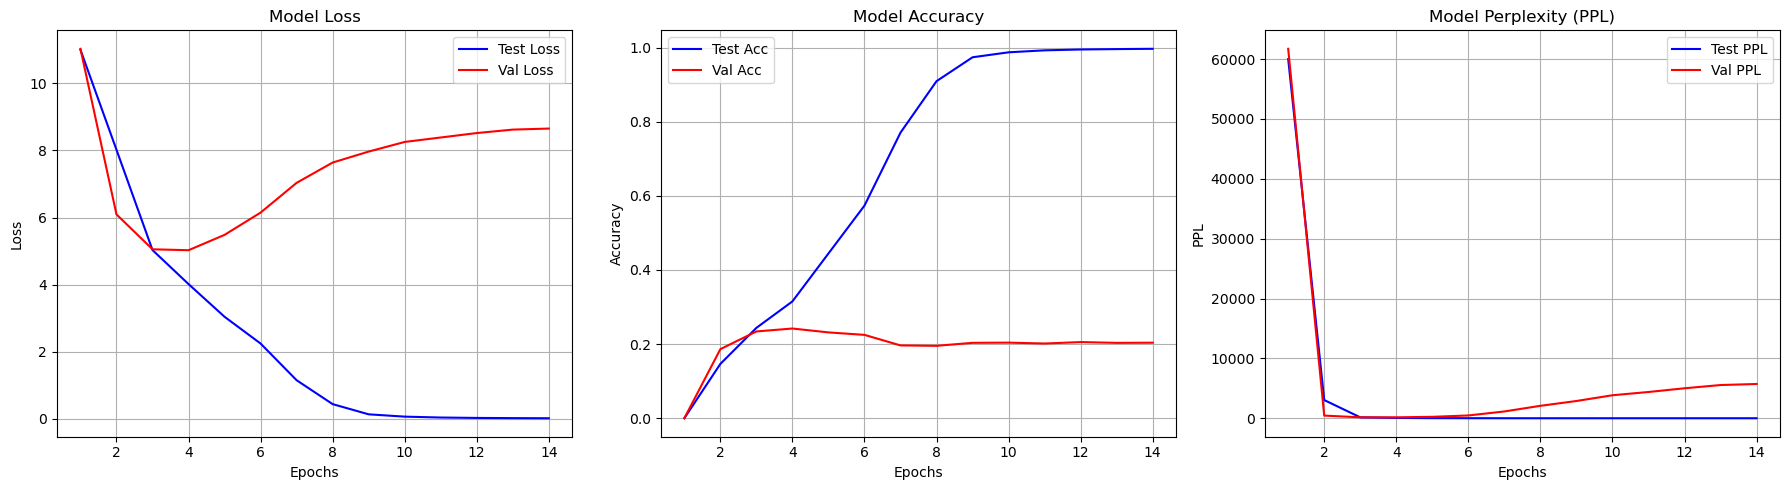

In [20]:
checkpoint_mode = True
if checkpoint_mode:
    history = torch.load(checkpoint_path, map_location=train_config.device)['history']

epochs = range(1, len(history['test_loss']) + 1)

# Tworzenie figury z 3 subpłotami
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Wykres Loss
axs[0].plot(epochs, history['test_loss'], 'b', label='Test Loss')
axs[0].plot(epochs, history['val_loss'], 'r', label='Val Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# 2. Wykres Accuracy
axs[1].plot(epochs, history['test_acc'], 'b', label='Test Acc')
axs[1].plot(epochs, history['val_acc'], 'r', label='Val Acc')
axs[1].set_title('Model Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

# 3. Wykres Perplexity (PPL)
axs[2].plot(epochs, history['test_ppl'], 'b', label='Test PPL')
axs[2].plot(epochs, history['val_ppl'], 'r', label='Val PPL')
axs[2].set_title('Model Perplexity (PPL)')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('PPL')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [21]:
model = WrexGPT(gpt_config)
model.load_state_dict(torch.load(checkpoint_path, map_location=train_config.device)['model_state_dict'])

generator = AutoregressiveGenerator(model,gpt_config, "cuda" if torch.cuda.is_available() else "cpu")

text = "Be or not to be"

genereted_text = generator.generate(text, max_new_tokens=70, greedy=False)

print(genereted_text)

Be or not to be all,
And are put their deaths.

CALUS:
What is he hath abused your powers.

ANGELO:

When:
Fear not too sudden; let's not, after-morrow.

ANGELO:
wixt most children's a licence in mine own.


Said
